In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [11]:
class MazeGame:
    def __init__(self):
        maze_layout = [[1, 1, 1, 1, 1, 1, 1],
               [1, 0, 0, 0, 0, 0, 1],
               [1, 0, 1, 1, 1, 0, 1],
               [1, 0, 1, 0, 0, 0, 1],
               [1, 0, 1, 1, 1, 1, 1],
               [1, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1]]
        """Initialize the maze game with a given layout."""
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        """Convert the maze layout to an RGB image."""
        rgb = np.zeros((*self.layout.shape, 3))  # Create a new RGB array
        for i in range(3):  # Copy the grayscale values into each RGB channel
            rgb[:, :, i] = 1 - self.layout
        return rgb

    def initialPosition(self, row, col):
        """Set the initial position in the maze."""
        if self.layout[row, col] == 0:
            self.start_pos = (row, col)
            self.current_pos = (row, col)
            self.set_point(row, col, [0, 0, 1])  # Mark initial position with blue
        else:
            print("Invalid initial position: It is on a wall.")

    def setExit(self, row, col):
        """Set the exit position in the maze."""
        if self.layout[row, col] == 0:
            self.exit_pos = (row, col)
            self.set_point(row, col, [0, 1, 0])  # Mark exit position with green
        else:
            print("Invalid exit position: It is on a wall.")

    def set_point(self, row, col, color):
        """Set a specific point in the maze to a given color."""
        self.rgb_maze[row, col] = color

    def makeMove(self, direction):
        """Attempt to move in the specified direction."""
        if self.current_pos is None:
            print("Initial position not set.")
            return 0

        row, col = self.current_pos
        if direction == "up":
            new_pos = (row - 1, col)
        elif direction == "down":
            new_pos = (row + 1, col)
        elif direction == "left":
            new_pos = (row, col - 1)
        elif direction == "right":
            new_pos = (row, col + 1)
        else:
            print("Invalid direction.")
            return 0

        if self.isValidMove(new_pos):
            self.current_pos = new_pos
            self.set_point(*self.start_pos, [1 - self.layout[self.start_pos]])  # Reset start position color
            self.start_pos = new_pos
            self.set_point(*new_pos, [0, 0, 1])  # Mark new position with blue
            if self.current_pos == self.exit_pos:
                # print("Success! You've found the way out.")
                return 1
        # else:
        #    print("Invalid move: Can't move through walls or out of bounds.")

    def isValidMove(self, pos):
        """Check if a move is valid (within bounds and not through walls)."""
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        """Plot the maze."""
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

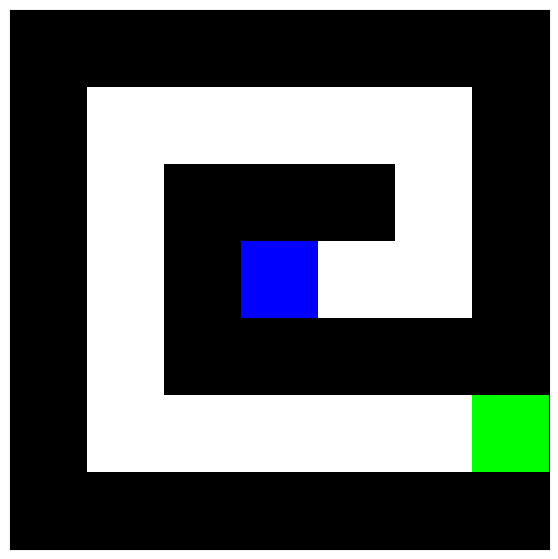

In [12]:
# Create an instance of MazeGame
maze_game = MazeGame()

# Set the initial and exit positions
maze_game.initialPosition(3, 3)
maze_game.setExit(5, 6)
maze_game.plot()

Model-based RL agent

In [39]:
class ModelBasedAgent:
    def __init__(self, game, gamma=0.99):
        print('At initialization, the map is given as', game.layout.shape)
        self.game = game
        self.gamma = gamma  # Discount factor
        self.values = np.zeros(game.layout.shape)
        print('At initialization, the value matrix is given as,', self.values)
        self.policy = np.full(game.layout.shape, 'hold', dtype=object)
        print('At initialization, the policy matrix is given as,', self.policy)
        self.actions = ['up', 'down', 'left', 'right']

    # Bellman optimization to find the optimal action trajectory.
    def find_the_optimal_trajectory_through_simulation(self, iterations=100):
        print('self.game.layout.shape[0]', self.game.layout.shape[0])
        print('self.game.layout.shape[1]', self.game.layout.shape[1])
        print('self.game.layout')
        print('self.game.layout', self.game.layout)
        for _ in range(iterations):
            new_values = np.copy(self.values)
            for row in range(self.game.layout.shape[0]):
                for col in range(self.game.layout.shape[1]):
                    print('At row ', row, 'and col, ', col, '\n')
                    if self.game.layout[row, col] == 0:  # Only update for navigable cells
                        state_value = []
                        for action in self.actions:
                            new_pos = self.predict_move((row, col), action)
                            reward = self.predict_reward((row, col), new_pos)
                            state_value.append(reward + self.gamma * self.values[new_pos])
                        best_action_value = max(state_value)
                        new_values[row, col] = best_action_value
                        self.policy[row, col] = self.actions[state_value.index(best_action_value)]
                        print('The action trajectory is updated to the following,', self.policy)
            self.values = new_values
            print('Value,', self.values)

    def predict_move(self, pos, action):
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))
        return new_pos if self.game.layout[new_pos] == 0 else pos

    def predict_reward(self, pos, new_pos):
        if new_pos == self.game.exit_pos:
            return 100  # Large reward for reaching the exit
        elif new_pos == pos:
            return -5  # Penalty for hitting a wall
        else:
            return -1  # Small penalty for each move to encourage shortest path

    def run_policy(self):
        print("Running policy...")
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            action = self.policy[current_pos]
            print(f"Step {steps}: at {current_pos} taking action {action}")
            self.game.makeMove(action)
            current_pos = self.game.current_pos
            steps += 1
            if steps > 50:  # Just in case something goes wrong
                print("Something went wrong. Stopping after 50 steps.")
                break

    def update_game(self, new_game):
        self.game = new_game

Simulation Run

In [40]:
# Initialize the model-based agent with the maze game and update its values
model_based_agent = ModelBasedAgent(maze_game)
model_based_agent.find_the_optimal_trajectory_through_simulation(100)  # Perform value iteration

# Now, run the agent's policy to see how it navigates the maze
model_based_agent.run_policy()

At initialization, the map is given as (7, 7)
At initialization, the value matrix is given as, [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
At initialization, the policy matrix is given as, [['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']]
self.game.layout.shape[0] 7
self.game.layout.shape[1] 7
self.game.layout
self.game.layout [[1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1]
 [1 0 1 0 0 0 1]
 [1 0 1 1 1 1 1]
 [1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]]
At row  0 and col,  0 

At row  0 and col,  1 

At row  0 and col,  2 

At row  0 and col,  3 

At row  0 and c

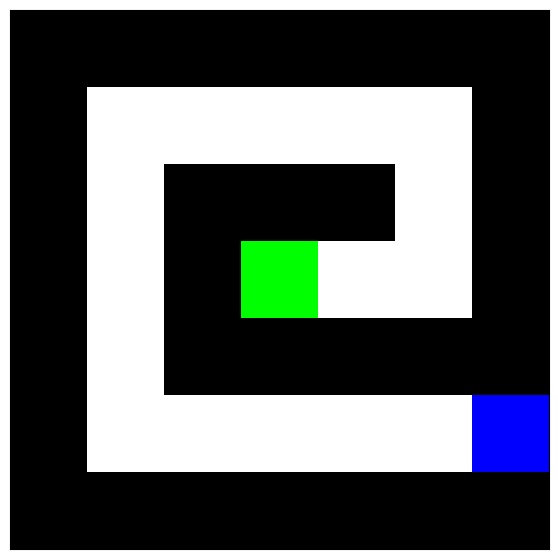

Running policy...
Step 0: at (5, 6) taking action up
Step 1: at (5, 6) taking action up
Step 2: at (5, 6) taking action up
Step 3: at (5, 6) taking action up
Step 4: at (5, 6) taking action up
Step 5: at (5, 6) taking action up
Step 6: at (5, 6) taking action up
Step 7: at (5, 6) taking action up
Step 8: at (5, 6) taking action up
Step 9: at (5, 6) taking action up
Step 10: at (5, 6) taking action up
Step 11: at (5, 6) taking action up
Step 12: at (5, 6) taking action up
Step 13: at (5, 6) taking action up
Step 14: at (5, 6) taking action up
Step 15: at (5, 6) taking action up
Step 16: at (5, 6) taking action up
Step 17: at (5, 6) taking action up
Step 18: at (5, 6) taking action up
Step 19: at (5, 6) taking action up
Step 20: at (5, 6) taking action up
Step 21: at (5, 6) taking action up
Step 22: at (5, 6) taking action up
Step 23: at (5, 6) taking action up
Step 24: at (5, 6) taking action up
Step 25: at (5, 6) taking action up
Step 26: at (5, 6) taking action up
Step 27: at (5, 6) t

In [41]:
# Set the initial and exit positions
maze_game.initialPosition(5, 6)
maze_game.setExit(3, 3)
maze_game.plot()
model_based_agent.update_game(maze_game)
model_based_agent.run_policy()

not punishment

In [50]:
class ModelBasedAgent:
    def __init__(self, game, gamma=0.99):
        print('At initialization, the map is given as', game.layout.shape)
        self.game = game
        self.gamma = gamma  # Discount factor
        self.values = np.zeros(game.layout.shape)
        print('At initialization, the value matrix is given as,', self.values)
        self.policy = np.full(game.layout.shape, 'hold', dtype=object)
        print('At initialization, the policy matrix is given as,', self.policy)
        self.actions = ['up', 'down', 'left', 'right']

    # Bellman optimization to find the optimal action trajectory.
    def find_the_optimal_trajectory_through_simulation(self, iterations=100):
        print('self.game.layout.shape[0]', self.game.layout.shape[0])
        print('self.game.layout.shape[1]', self.game.layout.shape[1])
        print('self.game.layout')
        print('self.game.layout', self.game.layout)
        for _ in range(iterations):
            new_values = np.copy(self.values)
            for row in range(self.game.layout.shape[0]):
                for col in range(self.game.layout.shape[1]):
                    print('At row ', row, 'and col, ', col, '\n')
                    if self.game.layout[row, col] == 0:  # Only update for navigable cells
                        state_value = []
                        print('self.actions', self.actions)
                        for action in self.actions:
                            new_pos = self.predict_move((row, col), action)
                            reward = self.predict_reward((row, col), new_pos)
                            state_value.append(reward + self.gamma * self.values[new_pos])
                        print('state_vale', state_value)
                        best_action_value = max(state_value)
                        print('best_action_value', best_action_value)
                        new_values[row, col] = best_action_value
                        print('new_values[row, col]', new_values[row, col] )
                        self.policy[row, col] = self.actions[state_value.index(best_action_value)]
                        print('The action trajectory is updated to the following,', self.policy)
            self.values = new_values
            print('Value,', self.values)

    def predict_move(self, pos, action):
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))
        return new_pos if self.game.layout[new_pos] == 0 else pos

    def predict_reward(self, pos, new_pos):
        if new_pos == self.game.exit_pos:
            return 100  # Large reward for reaching the exit
        else:
            return 0 # no penalty for each move to encourage shortest path

    def run_policy(self):
        print("Running policy...")
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            action = self.policy[current_pos]
            print(f"Step {steps}: at {current_pos} taking action {action}")
            self.game.makeMove(action)
            current_pos = self.game.current_pos
            steps += 1
            if steps > 50:  # Just in case something goes wrong
                print("Something went wrong. Stopping after 50 steps.")
                break

    def update_game(self, new_game):
        self.game = new_game

In [51]:
# Initialize the model-based agent with the maze game and update its values
model_based_agent = ModelBasedAgent(maze_game)
model_based_agent.find_the_optimal_trajectory_through_simulation(30)  # Perform value iteration

# Now, run the agent's policy to see how it navigates the maze
model_based_agent.run_policy()

At initialization, the map is given as (7, 7)
At initialization, the value matrix is given as, [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
At initialization, the policy matrix is given as, [['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']
 ['hold' 'hold' 'hold' 'hold' 'hold' 'hold' 'hold']]
self.game.layout.shape[0] 7
self.game.layout.shape[1] 7
self.game.layout
self.game.layout [[1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1]
 [1 0 1 0 0 0 1]
 [1 0 1 1 1 1 1]
 [1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]]
At row  0 and col,  0 

At row  0 and col,  1 

At row  0 and col,  2 

At row  0 and col,  3 

At row  0 and c

In [13]:
class ModelBasedAgent:
    def __init__(self, game, gamma=0.99):
        print('At initialization, the map is given as', game.layout.shape)
        self.game = game
        self.gamma = gamma  # Discount factor
        self.internal_model = np.zeros(game.layout.shape)
        self.values = np.zeros(game.layout.shape)
        self.epsilon = 0.1
        print('At initialization, the value matrix is given as,', self.values)
        self.policy = np.full(game.layout.shape, 'up', dtype=object)
        print('At initialization, the policy matrix is given as,', self.policy)
        self.actions = ['up', 'down', 'left', 'right']

    # Bellman optimization to find the optimal action trajectory.
    def value_iteration_of_bellman_update(self, iterations=100):
        print('self.game.layout.shape[0]', self.game.layout.shape[0])
        print('self.game.layout.shape[1]', self.game.layout.shape[1])
        print('self.game.layout')
        print('self.game.layout', self.game.layout)
        for _ in range(iterations):
            new_values = np.copy(self.values)
            for row in range(self.internal_model.shape[0]):
                for col in range(self.game.internal_model.shape[1]):
                    print('At row ', row, 'and col, ', col, '\n')
                    if self.game.layout[row, col] == 0:  # Only update for navigable cells
                        state_value = []
                        print('self.actions', self.actions)
                        for action in self.actions:
                            new_pos = self.predict_move((row, col), action)
                            reward = self.predict_reward(new_pos)
                            state_value.append(reward + self.gamma * self.values[new_pos])
                        print('state_vale', state_value)
                        best_action_value = max(state_value)
                        print('best_action_value', best_action_value)
                        new_values[row, col] = best_action_value
                        print('new_values[row, col]', new_values[row, col] )
                        self.policy[row, col] = self.actions[state_value.index(best_action_value)]
                        print('The action trajectory is updated to the following,', self.policy)
            self.values = new_values
            print('Value,', self.values)

    def move_outcome_if_there_is_no_wall(self, pos, action):
        new_pos = pos
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))
        return new_pos

    def predict_move(self, pos, action):
        new_pos = pos
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))

        # return current position if there is a wall; which is indicated with 1
        return pos if choose_with_probability(self.internal_model[new_pos]) else new_pos

    def predict_reward(self, new_pos):
        if new_pos == self.game.exit_pos:
            return 100  # Large reward for reaching the exit
        else:
            return 0 # no penalty for each move to encourage shortest path

    def latent_learning_of_internal_model(self):
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            old_position= self.game.current_pos

            # explore versus exploit
            if random.uniform(0, 1) < self.epsilon:
                action = random.choice(self.actions)  # Explore
            else:
                action = self.policy[current_pos]

            self.game.makeMove(action)
            current_pos = self.game.current_pos

            if old_position == current_pos:
                there_is_a_wall_at = self.move_outcome_if_there_is_no_wall(current_pos, action)
                print('action_is', action)
                print('there is a wall at,', there_is_a_wall_at)
                # update internal model
                self.internal_model[there_is_a_wall_at] = self.internal_model[there_is_a_wall_at] + 0.01
                print('internal_model', self.internal_model)
            steps += 1
            if steps > 30:  # each train wandering has 30 steps
                break

    def train(self, episodes=1000):
        for episode in range(episodes):
            self.game.initialPosition(3, 3)  # Reset to starting position
            self.latent_learning_of_internal_model()

    def run_policy(self):
        print("Running policy...")
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            action = self.policy[current_pos]
            print(f"Step {steps}: at {current_pos} taking action {action}")
            self.game.makeMove(action)
            current_pos = self.game.current_pos
            steps += 1
            if steps > 50:  # Just in case something goes wrong
                print("Something went wrong. Stopping after 50 steps.")
                break

    def update_game(self, new_game):
        self.game = new_game

In [14]:
agent = ModelBasedAgent(maze_game)
agent.train(10)

At initialization, the map is given as (7, 7)
At initialization, the value matrix is given as, [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
At initialization, the policy matrix is given as, [['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']]
action_is up
there is a wall at, (2, 3)
internal_model [[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
action_is up
there is a wall at, (2, 3)
internal_model [[0.   0.   0.   0.   0.   0.   0.  ]
 [0.

In [42]:
# This is the helper function for determining if there is a wall.
# For example, if the probability is given as 0.9, this means that
# there is 90% that there is a wall.
# With this helper function, we have .9 likelihood, to return 1
# which indicate there is a wall.

def choose_with_probability(s):
    return 1 if random.random() < s else 0

In [43]:
class ModelBasedAgent:
    def __init__(self, game, gamma=0.99):
        self.game = game
        self.gamma = gamma  # Discount factor
        self.internal_model = np.zeros(game.layout.shape)
        self.values = np.zeros(game.layout.shape)
        self.epsilon = 0.8
        self.policy = np.full(game.layout.shape, 'up', dtype=object)
        self.actions = ['up', 'down', 'left', 'right']

    # Bellman optimization to find the optimal action trajectory.
    def value_iteration_of_bellman_update(self, iterations=100):
        for _ in range(iterations):
            new_values = np.copy(self.values)
            for row in range(self.internal_model.shape[0]):
                for col in range(self.internal_model.shape[1]):
                    if self.game.layout[row, col] == 0:  # Only update for navigable cells
                        state_value = []
                        for action in self.actions:
                            new_pos = self.predict_move((row, col), action)
                            reward = self.predict_reward(new_pos)
                            state_value.append(reward + self.gamma * self.values[new_pos])
                        best_action_value = max(state_value)
                        new_values[row, col] = best_action_value
                        self.policy[row, col] = self.actions[state_value.index(best_action_value)]
            self.values = new_values

    def move_outcome_if_there_is_no_wall(self, pos, action):
        new_pos = pos
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))
        return new_pos

    def predict_move(self, pos, action):
        new_pos = pos
        if action == "up":
            new_pos = (max(0, pos[0]-1), pos[1])
        elif action == "down":
            new_pos = (min(self.game.layout.shape[0]-1, pos[0]+1), pos[1])
        elif action == "left":
            new_pos = (pos[0], max(0, pos[1]-1))
        elif action == "right":
            new_pos = (pos[0], min(self.game.layout.shape[1]-1, pos[1]+1))

        # return current position if there is a wall; which is indicated with 1
        return pos if choose_with_probability(self.internal_model[new_pos]) else new_pos

    def predict_reward(self, new_pos):
        if new_pos == self.game.exit_pos:
            return 100  # Large reward for reaching the exit
        else:
            return 0 # no penalty for each move to encourage shortest path

    def latent_learning_of_internal_model(self):
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            old_position= self.game.current_pos

            # explore versus exploit
            if random.uniform(0, 1) < self.epsilon:
                action = random.choice(self.actions)  # Explore
            else:
                action = self.policy[current_pos]

            self.game.makeMove(action)
            current_pos = self.game.current_pos

            if old_position == current_pos:
                there_is_a_wall_at = self.move_outcome_if_there_is_no_wall(current_pos, action)
                # update internal model
                self.internal_model[there_is_a_wall_at] = self.internal_model[there_is_a_wall_at] + 0.01
            steps += 1
            if steps > 5:  # each train wandering has 5 steps
                break

    def train(self, episodes=1000):
        for episode in range(episodes):
            self.game.initialPosition(3, 3)  # Reset to starting position
            print('Episode,', episode)
            print('Action policy', self.policy)
            print('Value,', self.values)
            print('Internal Model,', self.internal_model)
            self.latent_learning_of_internal_model()
            self.value_iteration_of_bellman_update()

    def run_policy(self):
        print("Running policy...")
        print('Action policy', self.policy)
        print('Value,', self.values)
        print('Internal Model,', self.internal_model)
        current_pos = self.game.current_pos
        steps = 0
        while current_pos != self.game.exit_pos:
            action = self.policy[current_pos]
            print(f"Step {steps}: at {current_pos} taking action {action}")
            self.game.makeMove(action)
            current_pos = self.game.current_pos
            steps += 1
            if steps > 50:  # Just in case something goes wrong
                print("Stopping after 50 steps.")
                break

    def update_game(self, new_game):
        self.game = new_game

In [44]:
agent = ModelBasedAgent(maze_game)
agent.train(1000)

Episode, 0
Action policy [['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']]
Value, [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Internal Model, [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Episode, 1
Action policy [['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'down' 'left' 'left' 'left' 'left' 'up']
 ['up' 'down' 'up' 'up' 'up' 'up' 'up']
 ['up' 'down' 'up' 'right' 'right' 'up' 'up']
 ['up' 'down' 'up' 'up' 'up' 'up' 'up']
 ['up' 'right' 'right' 'right' 'right' 'right' 'right']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']]
Value, [[   0. 

In [45]:
agent.run_policy()

Running policy...
Action policy [['up' 'up' 'up' 'up' 'up' 'up' 'up']
 ['up' 'down' 'left' 'left' 'left' 'left' 'up']
 ['up' 'down' 'up' 'up' 'up' 'up' 'up']
 ['up' 'down' 'up' 'right' 'right' 'up' 'up']
 ['up' 'down' 'up' 'up' 'up' 'up' 'up']
 ['up' 'right' 'right' 'right' 'right' 'right' 'right']
 ['up' 'up' 'up' 'up' 'up' 'up' 'up']]
Value, [[    0.             0.             0.             0.
      0.             0.             0.        ]
 [    0.          9227.44694428  9135.17247484  9043.82075009
   8953.38254259  8863.84871716     0.        ]
 [    0.          9320.65347907     0.             0.
      0.          8775.21022999     0.        ]
 [    0.          9414.80149401     0.          8514.57771095
   8600.58354641  8687.45812769     0.        ]
 [    0.          9509.900499       0.             0.
      0.             0.             0.        ]
 [    0.          9605.9601      9702.99        9801.
   9900.         10000.         10000.        ]
 [    0.             0.   